## Weather Data Network



In [3]:
import torch
import os

import timeit
import abc
from torch.autograd import Variable

import copy

from abc import ABC
from sklearn.model_selection import train_test_split


from numpy import linalg
# from geomloss import SamplesLoss

import torch

from mpl_toolkits.mplot3d import Axes3D  

from sklearn.metrics import mean_squared_error

In [4]:
# The linear model which implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [5]:
# The abstract optimizer model which should have model, optimizer, and criterion
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(5):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
#             print(y_pred.shape)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2) 
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()
    
    
# The Linear optimizer model which implemented by pytorch    
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)

In [6]:
# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u

    
# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u

In [9]:
import random
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import datetime as dt
# import geopy.distance
import networkx as nx
# from fmiopendata.wfs import download_stored_query

# read in raw data which has been downloaded from FMI 

data = pd.read_csv('FMIData.csv')
data = data.dropna(axis=0)
# determine number of different weather stations for which observations are available 

num_stations = len(data.station.unique())
# data.groupby(by='station').count()
print(num_stations)

203


In [10]:
def reset_model(G):
    '''
    reinitialize models
    '''
    for i in range(G.number_of_nodes()):
        G.nodes[i]['model'] = TorchLinearModel(3)
        G.nodes[i]['optimizer'] = TorchLinearOptimizer(G.nodes[i]['model'])
    return G

# def get_dist(graph,nodeA,nodeB):
#     """calculate the distance between two different stations"""
#     coord_1 = graph.nodes[nodeA]['coord']
#     coord_2 = graph.nodes[nodeB]['coord']
#     return geopy.distance.geodesic(coord_1, coord_2).miles

# def add_edges(graph,total_neigh=4):
#     num_nodes = graph.number_of_nodes()
    
#     for i in range(num_nodes):
#             node_dists = []
#             '''
#             a list containing the distance between node i and other nodes of the graph
#             '''
#             for j in range(num_nodes):
#                 if j == i:
#                     continue
#                 node_dists.append(get_dist(graph,i, j))

#             # sort node_dists in order to pick the nearest nodes to the node i 
#             node_dists.sort(reverse=False)
#             node_cnt = 0
#             for j in range(num_nodes):

#                 if node_cnt >= total_neigh:
#                     break

#                 if j == i:
#                     continue

#                 # calculate the distance between node i and j of the graph
#                 dist = get_dist(graph,i, j)
#                 if dist == 0 or dist >= node_dists[total_neigh]:
#                     continue
#                 node_cnt += 1
#                 graph.add_edge(i, j)
#                 graph.edges[i,j]['dist']=dist
#     return graph

In [11]:
def get_B_weight_vec(G):
    N = G.number_of_nodes()
    E = G.number_of_edges()
    '''
    N: total number of nodes
    E: total number of edges
    '''


    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''

    cnt = 0
    for i, j in G.edges:
        B[cnt, i] = 1
        B[cnt, j] = -1

        weight_vec[cnt] = 1/G.edges[i,j]['dist']
        cnt += 1
    return B, weight_vec

In [12]:
# add node attributes: station name,feature, and label
def set_up_graph(G_FMI):
    
    for i,station in enumerate(data.station.unique()):
        df = data[data.station==station]
        pre_1 = df['max_temp'].shift(1)
        df.insert(6, "pre_1", pre_1)
 
        df = df.iloc[1:]
        df['dummy'] = np.ones(df.shape[0])
        G_FMI.nodes[i]['name'] = station   # name of the i-th weather station
        G_FMI.nodes[i]['coord'] = (df.latitude.unique()[0],df.longitude.unique()[0]) # coordinates of i-th weather station 
        features =df[['pre_1','min_temp','dummy']].to_numpy()
        label = df.max_temp.to_numpy()
        X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.33)

        G_FMI.nodes[i]['X_train']= Variable(torch.from_numpy(X_train)).to(torch.float32)

        G_FMI.nodes[i]['y_train'] =Variable(torch.from_numpy(y_train)).to(torch.float32)  # label vector for local dataset at node i

        G_FMI.nodes[i]['X_val']= Variable(torch.from_numpy(X_val)).to(torch.float32)

        G_FMI.nodes[i]['y_val'] =Variable(torch.from_numpy(y_val)).to(torch.float32)  # label vector for local dataset at node i

        G_FMI.nodes[i]['model'] = TorchLinearModel(3)
        G_FMI.nodes[i]['optimizer'] = TorchLinearOptimizer(G_FMI.nodes[i]['model'])
    return G_FMI

# locally trained models

In [14]:
def train_val():
    G_FMI = nx.Graph()
    G_FMI.add_nodes_from(range(0,num_stations))
    G_FMI = set_up_graph(G_FMI)

    # train local models by using only local datapoints
    val_errors_local = []
    train_errors_local = []
    for i in range(G_FMI.number_of_nodes()):
        model =  G_FMI.nodes[i]['model']
        optimizer = torch.optim.RMSprop(model.parameters(),lr=0.01)
        criterion = torch.nn.MSELoss(reduction='mean')
        X_train = G_FMI.nodes[i]['X_train']
        y_train = G_FMI.nodes[i]['y_train'].reshape(-1,1)
        for j in range(1000):
            prediction = model(X_train)
            loss = criterion(prediction, y_train) 
            optimizer.zero_grad()
            loss.backward()        
            optimizer.step()
        train_errors_local.append(loss.detach().numpy())
        val_errors_local.append(criterion(model(G_FMI.nodes[i]['X_val']), G_FMI.nodes[i]['y_val'].reshape(-1,1)).detach().numpy())
    pid = os.getpid()
    print(pid)
    return np.mean(val_errors_local)

In [16]:
from joblib import Parallel, delayed

In [17]:
parallel = Parallel(n_jobs=-1,verbose=1)

out_local = parallel(delayed(train_val)() for i in range(5))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s finished


32423
32418
32416
32422
32414


In [20]:
np.mean(out_local) # averaged validation error of purely locally trained models

6.579283

# Networked models

In [27]:
def assign_edge(G,data,Loss,threshold=2):
    '''
    assign edge weights based on Wasserstein distance
    '''

    stations = data.station.unique()
    for i in range(203):
        for j in range(203):
            if i>j:
                df1 = data[data.station==stations[i]]
                pre_1 = df1['max_temp'].shift(1)
                df1.insert(6, "pre_1", pre_1)

                df1 = df1.iloc[1:]
                D1 = df1[['pre_1','min_temp','max_temp']].to_numpy()

                D1 = Variable(torch.from_numpy(D1)).to(torch.float32)

                df2 = data[data.station==stations[j]]
                pre_2 = df2['max_temp'].shift(1)
                df2.insert(6, "pre_2", pre_2)

                df2 = df2.iloc[1:]
                D2 = df2[['pre_2','min_temp','max_temp']].to_numpy()

                D2 = Variable(torch.from_numpy(D2)).to(torch.float32)
                dist = Loss(D1, D2).item()
                if dist < threshold:
                    G.add_edge(i, j)
                    G.edges[i,j]['dist']=dist
    zero_nodes = []
    for i in G.nodes:
        if G.degree(i)==0:
            zero_nodes.append(i)
#     print(zero_nodes)
    for i in zero_nodes:
        tmp = copy.deepcopy(zero_nodes)
        tmp.remove(i)
#         print(i)
        j = np.random.choice(tmp,size=1)[0]
#         print(i,j)
        G.add_edge(i, j)
        G.edges[i,j]['dist']=1000
#     return G

In [28]:
def algorithm_1(K, B, weight_vec, G, lambda_lasso, penalty_func_name='norm1'):
    '''
    :param K: the number of iterations 
    :param B: the block incidence matrix 
    :param weight_vec: a list containing the edges's weights of the graph
    
    :param lambda_lasso: the parameter lambda 
    :param penalty_func_name: the name of the penalty function used in the algorithm
    
    :return new_w: the predicted weigh vectors for each node
    '''
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    
    
    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(B), 0)))).ravel())
    
    '''
    T_matrix: the block diagonal matrix T
    '''

    E, N = B.shape
#     node_degrees = 3*np.ones(N)
#     T_matrix = np.ones([N,N])
    '''
    shape of the graph
    '''
    m, n = G.nodes[0]['X_train'].shape
    '''
    shape of the feature vectors of each node in the graph
    '''

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)
    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)
    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)
    else:
        raise Exception('Invalid penalty name')

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''
    
    # starting algorithm 1
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        
        prev_w = np.copy(new_w)

        # line 2 algorithm 1
        hat_w = new_w - np.dot(T_matrix, np.dot(B.T, new_u))
    
        
        for i in range(N):
            
            optimizer = G.nodes[i]['optimizer']
            
            new_w[i] = optimizer.optimize(G.nodes[i]['X_train'], 
                                          G.nodes[i]['y_train'], 
                                          hat_w[i], 
                                          node_degrees[i])
        
       
        # line 9 algortihm 1
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(B, tilde_w))
#         
        # line 10 algortihm 1
        new_u = penalty_func.update(new_u)


    return new_w

In [29]:
from geomloss import SamplesLoss
Loss =  SamplesLoss("sinkhorn", blur=0.001)

In [30]:
def lasso_train_val(threshold=5):
    """
    Calculate training errors and validation errors in all stations
    """
    
    G_FMI_lasso = nx.Graph()
    G_FMI_lasso.add_nodes_from(range(0,num_stations))
    G_FMI_lasso = set_up_graph(G_FMI_lasso)
    
    MSEs = []
    NUM_EDGEs = []
    Times = []
    
    assign_edge(G_FMI_lasso,data,Loss,threshold=threshold)
    number_edges = G_FMI_lasso.number_of_edges()
    B, weight_vec = get_B_weight_vec(G_FMI_lasso)
    print(weight_vec.shape)
            # Run lasso to train networked local models
    K=300
    lambda_lasso = 0.5

    start = timeit.default_timer()
    predicted_w = algorithm_1(K, B, weight_vec, G_FMI_lasso, lambda_lasso)
    stop = timeit.default_timer()
    time = stop - start
    Times.append(time)

    # calculate training errors and validation errors for networked models

    val_errors_lasso = []
    train_errors_lasso = []
    for i in range(203):
        val_pred = G_FMI_lasso.nodes[i]['X_val'].numpy().dot(predicted_w[i])
        val_true = G_FMI_lasso.nodes[i]['y_val'].numpy()
        val_error = mean_squared_error(val_pred,val_true)
        val_errors_lasso.append(val_error)

        train_pred = G_FMI_lasso.nodes[i]['X_train'].numpy().dot(predicted_w[i])
        train_true = G_FMI_lasso.nodes[i]['y_train'].numpy()
        train_error = mean_squared_error(train_pred,train_true)
        train_errors_lasso.append(train_error)
    MSEs.append(np.mean(val_errors_lasso))
    NUM_EDGEs.append(number_edges)
    G_FMI_lasso = nx.Graph()
    G_FMI_lasso.add_nodes_from(range(0,num_stations))
    G_FMI_lasso = set_up_graph(G_FMI_lasso)
    return np.mean(val_errors_lasso)
    


In [35]:
thresholds = [1,2,5,10,20,30]

parallel = Parallel(n_jobs=6,verbose=1)

num_runs = 5

out_lasso = parallel(delayed(lasso_train_val)(t) for t in thresholds for i in range(num_runs))


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


(192,)
(576,)
(3991,)
(8266,)
(13760,)
(192,)
(577,)
(3991,)
(8266,)
(16789,)
(192,)
(577,)
(3991,)
(13760,)
(16789,)


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed: 27.1min finished


In [87]:
NUM_EDGEs = [192, 576, 3991, 8266, 13760, 16789]

In [40]:
import pickle
# with open('results_FMI_wassarstein.pkl', 'wb') as f:
#     pickle.dump(out_lasso, f)

In [84]:
with open('results_FMI_wassarstein.pkl', 'rb') as f:
    results= pickle.load(f)
results = np.array(results)
results = results.reshape(6,5)

In [85]:
means = results.mean(axis = 1)
stds = results.std(axis = 1)

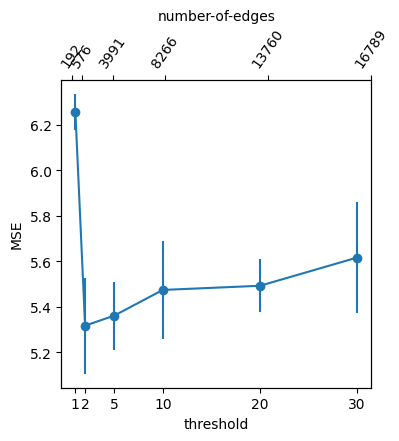

In [88]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.errorbar(thresholds,means,stds,fmt='-o')

# ax1.plot(thresholds,MSE_5runs.mean(axis=0))
ax1.set_xlabel("threshold")
ax1.set_ylabel("MSE")
tick_locations = np.array([1,2,5,10,20,30])
ax1.set_xticks(tick_locations)

# def tick_function(X):
#     V = 1/(1+X)
#     return ["%.3f" % z for z in V]

# ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(tick_locations)
ax2.set_xticklabels(NUM_EDGEs,rotation = 55)
ax2.set_xlabel("number-of-edges")
plt.show()

In [74]:
G_FMI_lasso = nx.Graph()
G_FMI_lasso.add_nodes_from(range(0,num_stations))
G_FMI_lasso = set_up_graph(G_FMI_lasso)

MSEs = []
NUM_EDGEs = []
Times = []

assign_edge(G_FMI_lasso,data,Loss,threshold=2)
number_edges = G_FMI_lasso.number_of_edges()
B, weight_vec = get_B_weight_vec(G_FMI_lasso)
print(weight_vec.shape)
        # Run lasso to train networked local models
K=300
lambda_lasso = 0.5

start = timeit.default_timer()
predicted_w = algorithm_1(K, B, weight_vec, G_FMI_lasso, lambda_lasso)
stop = timeit.default_timer()
time = stop - start
Times.append(time)

# calculate training errors and validation errors for networked models

val_errors_lasso = []
train_errors_lasso = []
for i in range(203):
    val_pred = G_FMI_lasso.nodes[i]['X_val'].numpy().dot(predicted_w[i])
    val_true = G_FMI_lasso.nodes[i]['y_val'].numpy()
    val_error = mean_squared_error(val_pred,val_true)
    val_errors_lasso.append(val_error)

    train_pred = G_FMI_lasso.nodes[i]['X_train'].numpy().dot(predicted_w[i])
    train_true = G_FMI_lasso.nodes[i]['y_train'].numpy()
    train_error = mean_squared_error(train_pred,train_true)
    train_errors_lasso.append(train_error)
MSEs.append(np.mean(val_errors_lasso))
NUM_EDGEs.append(number_edges)
G_FMI_lasso = nx.Graph()
G_FMI_lasso.add_nodes_from(range(0,num_stations))
G_FMI_lasso = set_up_graph(G_FMI_lasso)

(577,)


In [76]:
G_FMI = nx.Graph()
G_FMI.add_nodes_from(range(0,num_stations))
G_FMI = set_up_graph(G_FMI)

# train local models by using only local datapoints
val_errors_local = []
train_errors_local = []
for i in range(G_FMI.number_of_nodes()):
    model =  G_FMI.nodes[i]['model']
    optimizer = torch.optim.RMSprop(model.parameters(),lr=0.01)
    criterion = torch.nn.MSELoss(reduction='mean')
    X_train = G_FMI.nodes[i]['X_train']
    y_train = G_FMI.nodes[i]['y_train'].reshape(-1,1)
    for j in range(1000):
        prediction = model(X_train)
        loss = criterion(prediction, y_train) 
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
    train_errors_local.append(loss.detach().numpy())
    val_errors_local.append(criterion(model(G_FMI.nodes[i]['X_val']), G_FMI.nodes[i]['y_val'].reshape(-1,1)).detach().numpy())
    

In [77]:
## Compare validation errors, our method wins.

print('Average validation error of lasso models:',np.mean(val_errors_lasso))

print('\nAverage validation error of locally trained models:',np.mean(val_errors_local))


Average validation error of lasso models: 5.126081692433897

Average validation error of locally trained models: 6.2237325


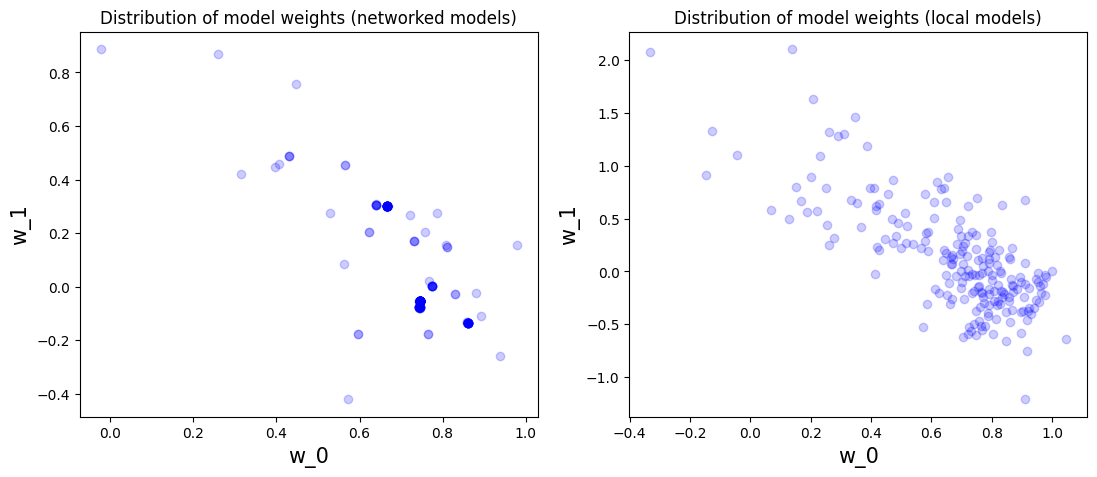

In [81]:
## Distribution of trained model weights: networked lasso V.S. pure local, the former resulted clustered models.

fig = plt.figure(figsize = (13,5))
ax1 = fig.add_subplot(121)
ax1.scatter(predicted_w[:,0],predicted_w[:,1],color='b',alpha=0.2)
ax1.set_title('Distribution of model weights (networked models)',fontsize=12)
ax1.set_xlabel('w_0',fontsize=15)
ax1.set_ylabel('w_1',fontsize=15)

ax2 = fig.add_subplot(122)
ax2.scatter(local_w[:,0],local_w[:,1],color='b',alpha=0.2)
ax2.set_title('Distribution of model weights (local models)',fontsize=12)
ax2.set_xlabel('w_0',fontsize=15)
ax2.set_ylabel('w_1',fontsize=15)

plt.show()

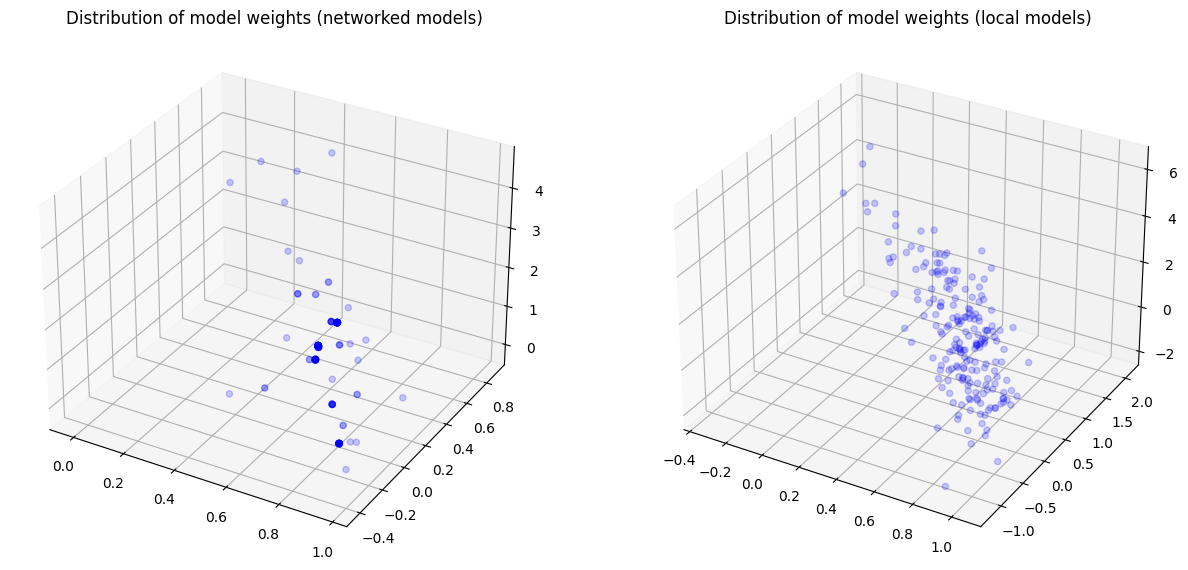

In [92]:
## in 3D view

local_w = np.zeros([203,3])
for i in range(203):
    weights = G_FMI.nodes[i]['model'].linear.weight.data.numpy()
    local_w[i] = weights

fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(predicted_w[:, 0], predicted_w[:, 1], predicted_w[:,2],color='b',alpha=0.2)
ax1.set_title('Distribution of model weights (networked models)',fontsize=12)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(local_w[:, 0], local_w[:, 1], local_w[:,2],color='b',alpha=0.2)
ax2.set_title('Distribution of model weights (local models)',fontsize=12)
plt.show()